In [1]:
import os
import cv2
import numpy as np

from torch.utils.data import DataLoader

import argus
from argus import Model
from argus.callbacks import MonitorCheckpoint, EarlyStopping
from argus.callbacks import LoggingToFile, ReduceLROnPlateau

from src.datasets import DrawDataset, get_train_val_samples
from src.transforms import ImageTransform, DrawTransform
from src.argus_models import CnnFinetune, DrawMetaModel
from src.metrics import MAPatK
from src import config

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def imshow(image, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.show()

In [3]:
image_size = 128
scale_size = 128
image_pad = 4
image_line_width = 2
time_color = True
train_batch_size = 256
val_batch_size = 256
train_epoch_size = 1000000
val_key_id_path = '/workdir/data/val_key_ids_001.json'

# Data

In [4]:
train_samples, val_samples = get_train_val_samples(val_key_id_path)

100%|██████████| 340/340 [03:47<00:00,  1.49it/s]


In [5]:
draw_transform = DrawTransform(image_size, image_pad, image_line_width, time_color)
train_trns = ImageTransform(True, scale_size)
train_dataset = DrawDataset(train_samples, draw_transform,
                            size=train_epoch_size, image_transform=train_trns)
val_trns = ImageTransform(False, scale_size)
val_dataset = DrawDataset(val_samples, draw_transform, image_transform=val_trns)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, num_workers=16, shuffle=False)

pants


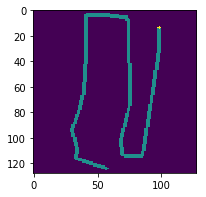

hospital


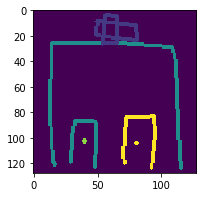

frying pan


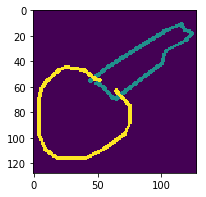

In [6]:
n_images_to_draw = 3

for img, trg in train_loader:
    for i in range(n_images_to_draw):
        img_i = img[0][i, 0, :, :].numpy()
        print(config.IDX_TO_CLASS[trg[i].item()])
        imshow(img_i)
    break

# Model

In [7]:
params = {
    'nn_module': ('CountryEmbModel' ,{
        'cnn_finetune': {
            'model_name': 'se_resnet50',
            'num_classes': len(config.CLASSES),
            'pretrained': True,
            'dropout_p': 0.2
        },
        'num_country': len(config.COUNTRIES),
        'country_emb_dim': 10
    }),
    'optimizer': ('Adam', {'lr': 0.001}),
    'loss': 'CrossEntropyLoss',
    'device': 'cuda'
}

model = DrawMetaModel(params)

In [ ]:
experiment_name = 'rainbow_country_se_resnet50_001'

callbacks = [
    MonitorCheckpoint(f'/workdir/data/experiments/{experiment_name}', monitor='val_map_at_k', max_saves=3),
    EarlyStopping(monitor='val_map_at_k', patience=50),
    ReduceLROnPlateau(monitor='val_map_at_k', factor=0.64, patience=3, min_lr=0.00001),
    LoggingToFile(f'/workdir/data/experiments/{experiment_name}/log.txt')
]

model.fit(train_loader, 
          val_loader=val_loader,
          max_epochs=1000,
          callbacks=callbacks,
          metrics=['accuracy', MAPatK(k=3)])

/usr/local/lib/python3.6/site-packages/argus/callbacks/checkpoints.py:28: UserWarning: Directory '/workdir/data/experiments/rainbow_country_se_resnet50_001' already exists
  warnings.warn(f"Directory '{dir_path}' already exists")
2018-11-05 20:24:17,833 INFO Validation, val_loss: 5.84671553, val_accuracy: 0.00287651, val_map_at_k: 0.00508586
2018-11-05 21:04:24,024 INFO Train - Epoch: 1, LR: 0.001, train_loss: 1.41464293
2018-11-05 21:05:13,917 INFO Validation - Epoch: 1, val_loss: 1.12286988, val_accuracy: 0.71100115, val_map_at_k: 0.78616928
2018-11-05 21:05:14,035 INFO Model saved to '/workdir/data/experiments/rainbow_country_se_resnet50_001/model-001-0.786169.pth'
2018-11-05 21:45:21,205 INFO Train - Epoch: 2, LR: 0.001, train_loss: 1.04351252
2018-11-05 21:46:11,159 INFO Validation - Epoch: 2, val_loss: 1.01405017, val_accuracy: 0.73791564, val_map_at_k: 0.80802138
2018-11-05 21:46:11,279 INFO Model saved to '/workdir/data/experiments/rainbow_country_se_resnet50_001/model-002-0.80

# Predict 

In [11]:
import torch


class Predictor:
    def __init__(self, model_path, draw_transform, image_transform):
        self.model = load_model(model_path)
        self.model.nn_module.eval()

        self.draw_transform = draw_transform
        self.image_transform = image_transform

    def __call__(self, samples):
        tensors = []
        country_tensors = []
        for drawing, country in samples:
            image = self.draw_transform(drawing)
            tensor = self.image_transform(image)
            if country == 'OTHER':
                country = 'nan'
            country = torch.tensor(config.COUNTRY_TO_IDX[country])
            country_tensors.append(country)
            tensors.append(tensor)
        
        tensor = torch.stack(tensors, dim=0)
        tensor = tensor.to(self.model.device)
        
        country_tensor = torch.stack(country_tensors, dim=0)
        country_tensor = country_tensor.to(self.model.device)

        with torch.no_grad():
            probs = self.model.predict((tensor, country_tensor))
            return probs


In [12]:
import pandas as pd
from src import config
import tqdm

from argus import load_model

pred_batch_size = 1024 
model_path = '/workdir/data/experiments/rainbow_country_se_resnet50_001/model-108-0.881537.pth'

test_df = pd.read_csv(config.TEST_SIMPLIFIED_PATH)
sample_subm = pd.read_csv(config.SAMPLE_SUBMISSION)
predictor = Predictor(model_path, draw_transform, val_trns)

drawings = []
key_ids = []
pred_words = []
pred_key_ids = []
for i, row in tqdm.tqdm(test_df.iterrows()):
    drawing = eval(row.drawing)
    
    drawings.append((drawing, str(row.countrycode)))
    key_ids.append(row.key_id)
    if len(drawings) == pred_batch_size:
        probs = predictor(drawings).cpu().numpy()
        preds_idx = probs.argsort(axis=1)
        preds_idx = np.fliplr(preds_idx)[:, :3]
        for pred_idx, key_id in zip(preds_idx, key_ids):
            words = [config.IDX_TO_CLASS[i].replace(' ', '_') for i in pred_idx]
            pred_words.append(" ".join(words))
            pred_key_ids.append(key_id)
            
        drawings = []
        key_ids = []
        
probs = predictor(drawings).cpu().numpy()
preds_idx = probs.argsort(axis=1)
preds_idx = np.fliplr(preds_idx)[:, :3]
for pred_idx, key_id in zip(preds_idx, key_ids):
    words = [config.IDX_TO_CLASS[i].replace(' ', '_') for i in pred_idx]
    pred_words.append(" ".join(words))
    pred_key_ids.append(key_id)

drawings = []
key_ids = []
    
subm = pd.DataFrame({'key_id': pred_key_ids, 'word': pred_words})

112199it [06:20, 294.83it/s]


In [13]:
subm.to_csv('/workdir/data/second_subm.csv', index=False)